In [1]:
## 1.Import libraries

import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import joblib

In [2]:
## 2.Load data

user_data = np.load('data/user_data.npy')
item_data = np.load('data/item_data.npy')
y_truth   = np.load('data/rating_data.npy')

In [3]:
## 3.Split data into train, test sets

item_train, item_test = train_test_split(item_data, train_size=0.99, shuffle=True, random_state=42)
user_train, user_test = train_test_split(user_data, train_size=0.99, shuffle=True, random_state=42)
y_train, y_test       = train_test_split(y_truth,   train_size=0.99, shuffle=True, random_state=42)
print(f"user train data shape: {user_train.shape}")
print(f"user test data shape: {user_test.shape}")
print(f"item train data shape: {item_train.shape}")
print(f"item test data shape: {item_test.shape}")
print(f"targets train data shape: {item_train.shape}")
print(f"targets test data shape: {item_test.shape}")

user train data shape: (5119329, 41)
user test data shape: (51711, 41)
item train data shape: (5119329, 75)
item test data shape: (51711, 75)
targets train data shape: (5119329, 75)
targets test data shape: (51711, 75)


In [4]:
## 4.Scale data

# Scale item data
scalerItem = MinMaxScaler()
scalerItem.fit(item_train)
item_train_np = scalerItem.transform(item_train).astype(np.float32)
item_test_np  = scalerItem.transform(item_test).astype(np.float32)

# Scale user data
scalerUser = MinMaxScaler()
scalerUser.fit(user_train)
user_train_np = scalerUser.transform(user_train).astype(np.float32)
user_test_np  = scalerUser.transform(user_test).astype(np.float32)

# Scale the true ratings
scalerTarget = MinMaxScaler()
scalerTarget.fit(y_train.reshape(-1, 1))
y_train = scalerTarget.transform(y_train.reshape(-1, 1)).astype(np.float32)
y_test  = scalerTarget.transform( y_test.reshape(-1, 1)).astype(np.float32)

In [5]:
## 5.Define variables

num_user_features = user_train_np.shape[1]
num_item_features = item_train_np.shape[1]
num_samples       = item_train_np.shape[0]

In [6]:
num_user_features, num_item_features, num_samples

(41, 75, 5119329)

In [7]:
## 6.Define model

class RecommendationModel:
    def __init__(self, num_user_features, num_item_features):
        self.num_outputs       = 32 #32
        self.num_user_features = num_user_features
        self.num_item_features = num_item_features
        self.num_samples       = num_samples
        self.batch_size        = 64

    def build_model(self, learning_rate, l2_reg):
        tf.random.set_seed(42)
        
        def dense_layer(units):
            return tf.keras.layers.Dense(units=units, activation='relu', 
                                         kernel_regularizer = tf.keras.regularizers.l2(l2_reg),
                                        )
            
        user_NN = tf.keras.models.Sequential([
            dense_layer(units=36),  #36
            tf.keras.layers.Dense(units=self.num_outputs, activation='linear')
        ])
        input_user = tf.keras.layers.Input(shape=(self.num_user_features))
        vu         = user_NN(input_user)
        vu         = tf.linalg.l2_normalize(vu, axis=1)

        item_NN = tf.keras.models.Sequential([
            dense_layer(units=60),  #60
            tf.keras.layers.Dense(units=self.num_outputs, activation='linear')
        ])
        input_item = tf.keras.layers.Input(shape=(self.num_item_features))
        vm         = item_NN(input_item)
        vm         = tf.linalg.l2_normalize(vm, axis=1)
        output     = tf.keras.layers.Dot(axes=1)([vu, vm])
        model      = tf.keras.Model([input_user, input_item], output)
        self.model = model
        
        self.early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor              ='val_loss',       # Monitor validation loss for improvement
            patience             = 5,               # Number of epochs with no improvement after which training will be stopped
            restore_best_weights = True  # Restore model weights from the epoch with the best value of the monitored quantity
        )

        lr_schedule = keras.optimizers.schedules.ExponentialDecay(
                                                initial_learning_rate = learning_rate,
                                                decay_steps           = 10000, #10000
                                                decay_rate=0.925)
        
        self.model.compile(
            optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule),
            loss      = tf.keras.losses.MeanSquaredError(), 
            metrics   = tf.keras.metrics.RootMeanSquaredError(name='RMSE')
                     )

    def train(self, user, item, y_train, num_epochs):
        history = self.model.fit(
            [user, item],
            y_train,
            epochs=num_epochs,
            batch_size=self.batch_size,
            validation_split=0.01,
            callbacks=[self.early_stopping],
            verbose=1,
            use_multiprocessing=True)
        self.saved_weights = self.model.get_weights()
        return history
    
#     def continue_training(self, user, item, y_train, num_epochs):
#         self.model.set_weights(self.saved_weights)
#         history = self.train(user, item, y_train, num_epochs)
#         return history

    def test(self, user, item, y_test):
        return self.model.evaluate([user, item], y_test)
    
    def recommend(self, user, item):
        return self.model.predict([user, item])
    
    def save_model(self, path):
        self.model.save(path + 'model.keras')


In [8]:
## 7.Execute training

rec_model = RecommendationModel(num_user_features, num_item_features)
rec_model.build_model(learning_rate=0.001, l2_reg=0.0001) #0.001, 0.001
history = rec_model.train(user_train_np, item_train_np, y_train, num_epochs=100)
print('\n')
test_error = rec_model.test(user_test_np, item_test_np, y_test)

Epoch 1/100
79190/79190 [==============================] - 112s 1ms/step - loss: 0.0320 - RMSE: 0.1757 - val_loss: 0.0303 - val_RMSE: 0.1717
Epoch 2/100
79190/79190 [==============================] - 95s 1ms/step - loss: 0.0302 - RMSE: 0.1715 - val_loss: 0.0294 - val_RMSE: 0.1696
Epoch 3/100
79190/79190 [==============================] - 93s 1ms/step - loss: 0.0295 - RMSE: 0.1700 - val_loss: 0.0293 - val_RMSE: 0.1694
Epoch 4/100
79190/79190 [==============================] - 95s 1ms/step - loss: 0.0291 - RMSE: 0.1690 - val_loss: 0.0289 - val_RMSE: 0.1684
Epoch 5/100
79190/79190 [==============================] - 102s 1ms/step - loss: 0.0288 - RMSE: 0.1683 - val_loss: 0.0286 - val_RMSE: 0.1678
Epoch 6/100
79190/79190 [==============================] - 97s 1ms/step - loss: 0.0286 - RMSE: 0.1678 - val_loss: 0.0285 - val_RMSE: 0.1675
Epoch 7/100
79190/79190 [==============================] - 106s 1ms/step - loss: 0.0285 - RMSE: 0.1676 - val_loss: 0.0284 - val_RMSE: 0.1673
Epoch 8/100
79190

range(1, 25)


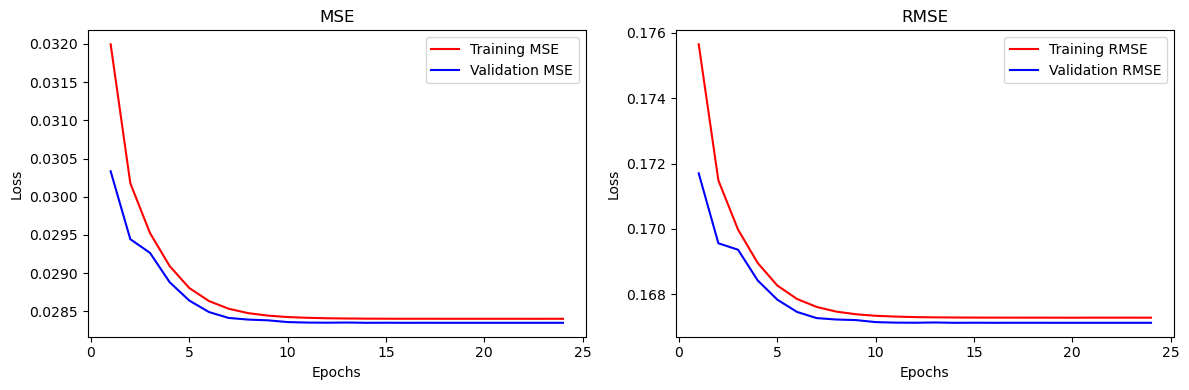

In [9]:
## 8.Plot results

def plot_training_history(history):
    # Get training and validation loss values
    tMSE = history.history['loss']
    vMSE = history.history['val_loss']
    tRMSE = history.history['RMSE']  # Assuming RMSE is stored in 'root_mean_squared_error'
    vRMSE = history.history['val_RMSE']  # Assuming RMSE is stored in 'val_root_mean_squared_error'

    # Create an array of epoch numbers
    epochs = range(1, len(tMSE) + 1)
    print(epochs)
    # Create subplots for MSE and RMSE
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot MSE
    ax1.plot(epochs, tMSE, 'red', label='Training MSE')
    ax1.plot(epochs, vMSE, 'blue', label='Validation MSE')
    ax1.set_title('MSE')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot RMSE
    ax2.plot(epochs, tRMSE, 'red', label='Training RMSE')
    ax2.plot(epochs, vRMSE, 'blue', label='Validation RMSE')
    ax2.set_title('RMSE')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.tight_layout()
    plt.show()

# Assuming history contains the training history
plot_training_history(history)


In [10]:
# 9.Save the model and the Scalers
MODEL_PATH = 'api_calls/'
rec_model.save_model(MODEL_PATH)

joblib.dump(scalerUser,   MODEL_PATH + 'scalerUser.pkl')
joblib.dump(scalerItem,   MODEL_PATH + 'scalerItem.pkl')
joblib.dump(scalerTarget, MODEL_PATH + 'scalerTarget.pkl')

['api_calls/scalerTarget.pkl']